<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>"Глубокое обучение". Продвинутый поток</b></h3>

In [22]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

%matplotlib inline

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


## 0. Data preparation

In [23]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=128,
    shuffle=True,
    num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=100,
    shuffle=False,
    num_workers=2
)

Files already downloaded and verified
Files already downloaded and verified


## 1. Custom Convolutional model

Попробуем написать свою собственную маленькую конволюционную модель

In [24]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [25]:
model = nn.Sequential()

# dense "head"
model.add_module('conv1', nn.Conv2d(3, 64, 3))
model.add_module('conv1_relu', nn.ReLU())
model.add_module('conv2', nn.Conv2d(64, 10, 3))
model.add_module('conv2_relu', nn.ReLU())

model.add_module('flat', Flatten())
model.add_module('dense', nn.Linear(10*28*28, 10))

In [26]:
import torchsummary

In [27]:
torchsummary.summary(model.cuda(), (3, 32, 32))

AssertionError: Torch not compiled with CUDA enabled

## 2. Write train and test function

In [28]:
def train(model, optim, criterion, dataloader, epoch, device):
    total = 0
    correct = 0
    train_loss = 0

    model.train()
    for data, label in dataloader:
        data, label = data.to(device), label.to(device)
        optim.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optim.step()

        train_loss += loss.item()
        pred = output.argmax(1)
        total += output.shape[0]
        correct += pred.eq(label).sum().item()
    return train_loss / total, 100. * correct / total

In [29]:
def test(model, criterion, dataloader, epoch, device, best_acc, model_name='model'):
    total = 0
    correct = 0
    test_loss = 0

    model.eval()
    with torch.no_grad():
        for data, label in dataloader:
            data, label = data.to(device), label.to(device)
            output = model(data)

            loss = criterion(output, label)

            test_loss += loss
            pred = output.argmax(1)
            correct += torch.eq(pred, label).sum().item()
            total += data.shape[0]

    acc = 100.*correct/total
    if acc > best_acc:
        # print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt_{}.pth'.format(model_name))

    return test_loss / total, acc


## 3. Train Model

In [30]:
from IPython.display import clear_output
import numpy as np

In [31]:
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

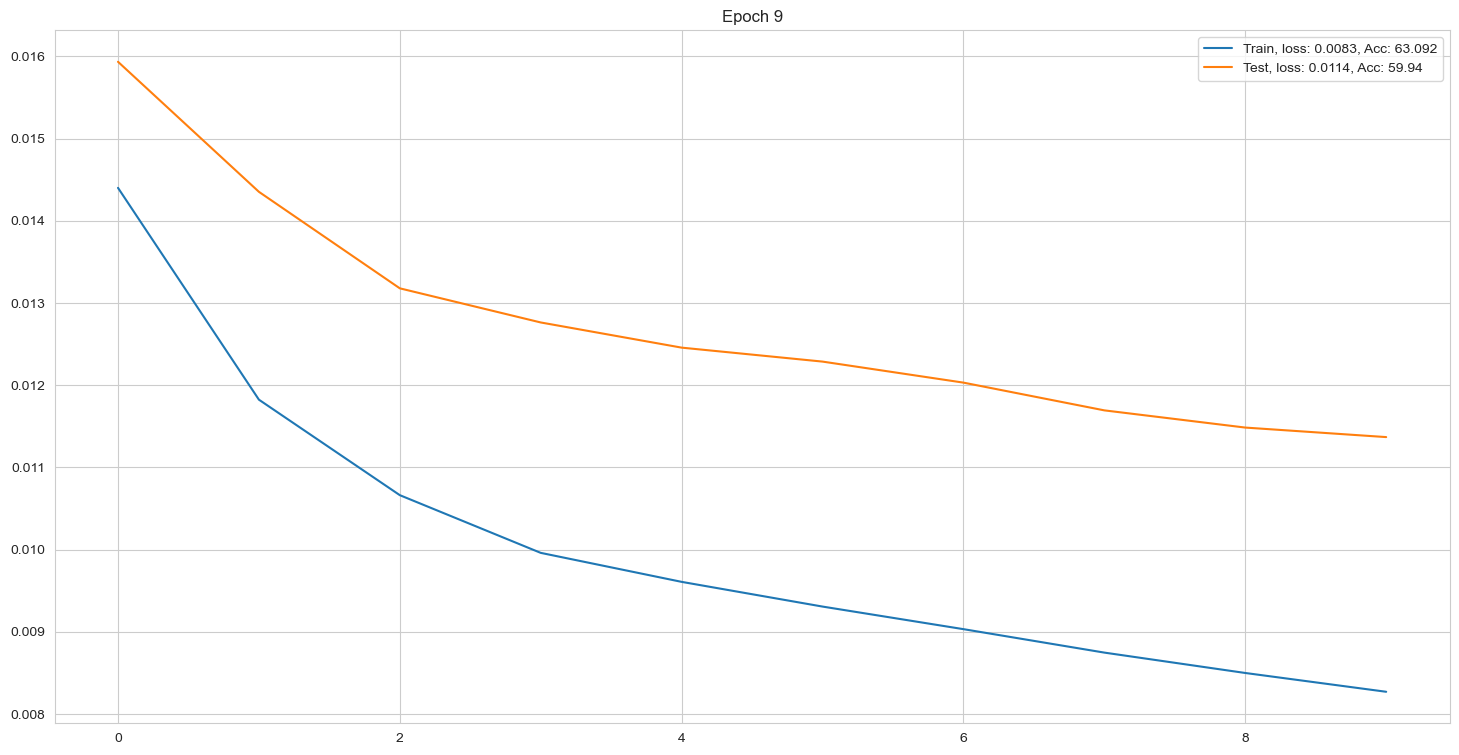

In [32]:
train_losses = []
test_losses = []
best_acc = 0
best_epoch = -1
for i in range(10):
    train_loss, train_acc = train(model, optimizer, criterion, trainloader, i, device)
    train_losses.append(train_loss)
    test_loss, test_acc = test(model, criterion, testloader, i, device, best_acc)
    scheduler.step(test_loss)
    test_losses.append(test_loss)
    best_acc = max(best_acc, test_acc)
    best_epoch = i if best_acc == test_acc else best_epoch
    clear_output()
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
    plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
    plt.title(f'Epoch {i}')
    plt.legend(loc='best')
    plt.show()

In [33]:
best_acc

59.94

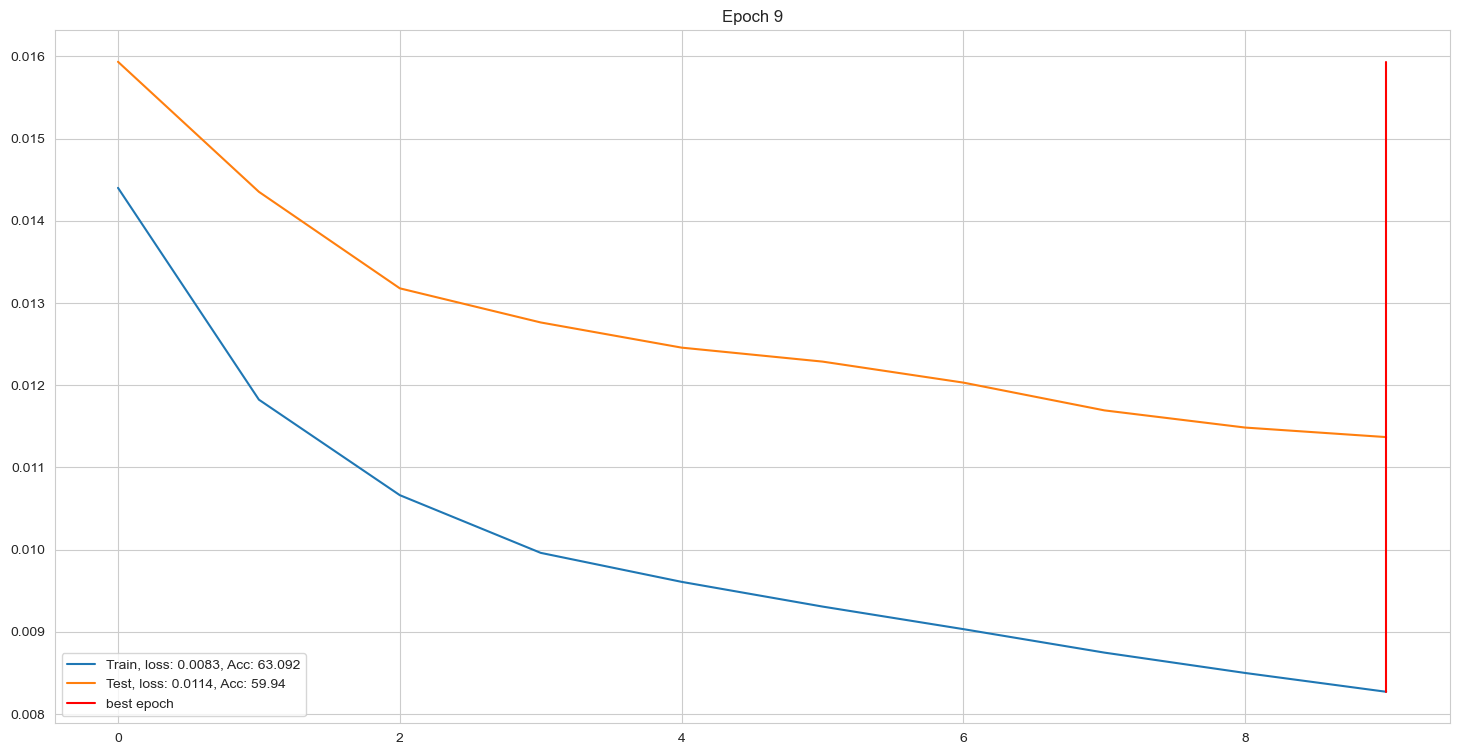

In [34]:
plt.figure(figsize=(18, 9))
plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
plt.plot(np.ones(10)*best_epoch, np.linspace(np.min(train_losses).item(), np.max(test_losses).item(), 10), color='r', label='best epoch')
plt.title(f'Epoch {i}')
plt.legend(loc='best')

### BatchNorm

https://arxiv.org/abs/1502.03167

![](https://standardfrancis.files.wordpress.com/2015/04/screenshot-from-2015-04-16-133436.png)

In [35]:
model = nn.Sequential()

# dense "head"
model.add_module('conv1', nn.Conv2d(3, 64, 3))
model.add_module('bn1', nn.BatchNorm2d(64))
model.add_module('conv1_relu', nn.ReLU())
model.add_module('conv2', nn.Conv2d(64, 10, 3))
model.add_module('bn2', nn.BatchNorm2d(10))
model.add_module('conv2_relu', nn.ReLU())

model.add_module('flat', Flatten())
model.add_module('dense', nn.Linear(10*28*28, 10))

In [36]:
torchsummary.summary(model.cuda(), (3, 32, 32))

AssertionError: Torch not compiled with CUDA enabled

In [37]:
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

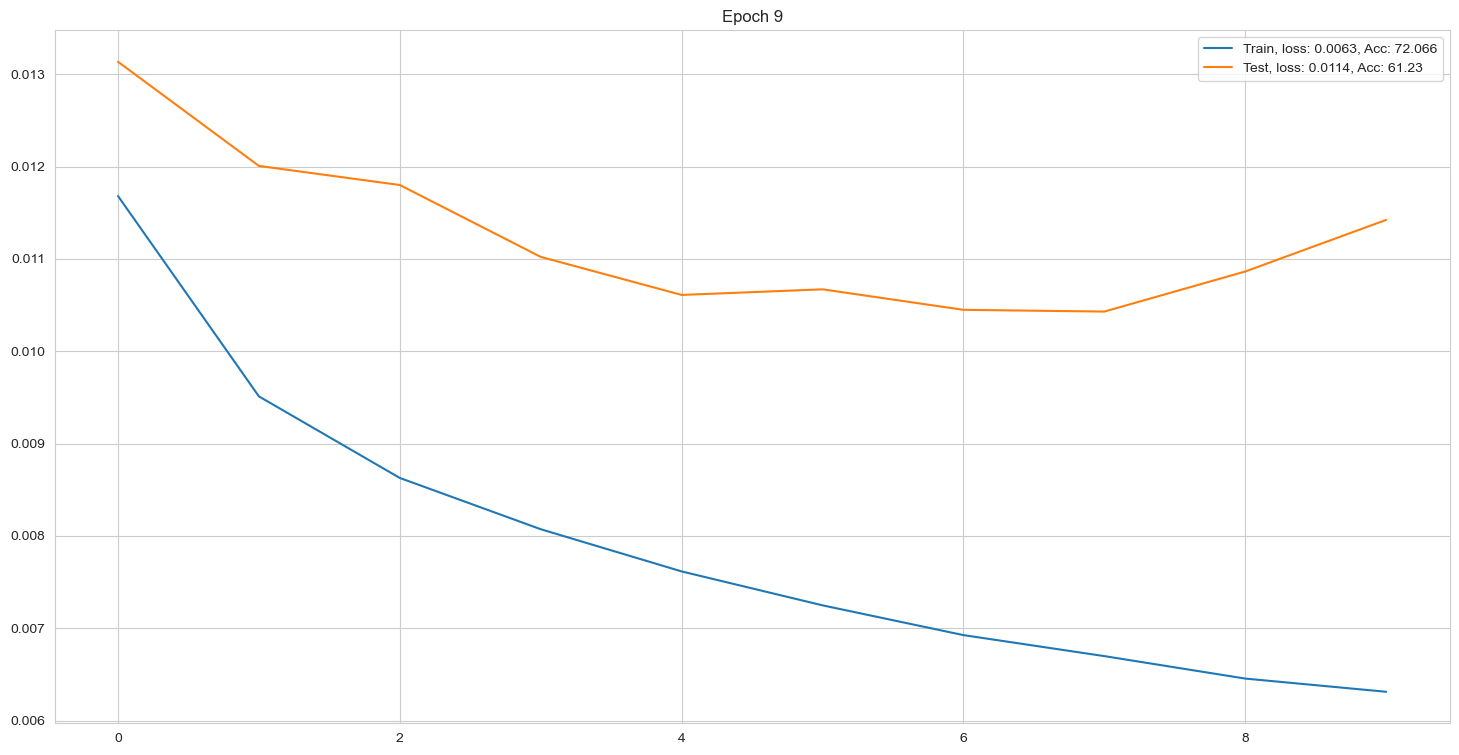

In [38]:
train_losses = []
test_losses = []
best_acc = 0
best_epoch = -1
for i in range(10):
    train_loss, train_acc = train(model, optimizer, criterion, trainloader, i, device)
    train_losses.append(train_loss)
    test_loss, test_acc = test(model, criterion, testloader, i, device, best_acc, 'with_bn')
    scheduler.step(test_loss)
    test_losses.append(test_loss)
    best_acc = max(best_acc, test_acc)
    best_epoch = i if best_acc == test_acc else best_epoch
    clear_output()
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
    plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
    plt.title(f'Epoch {i}')
    plt.legend(loc='best')
    plt.show()

In [39]:
best_acc

64.04

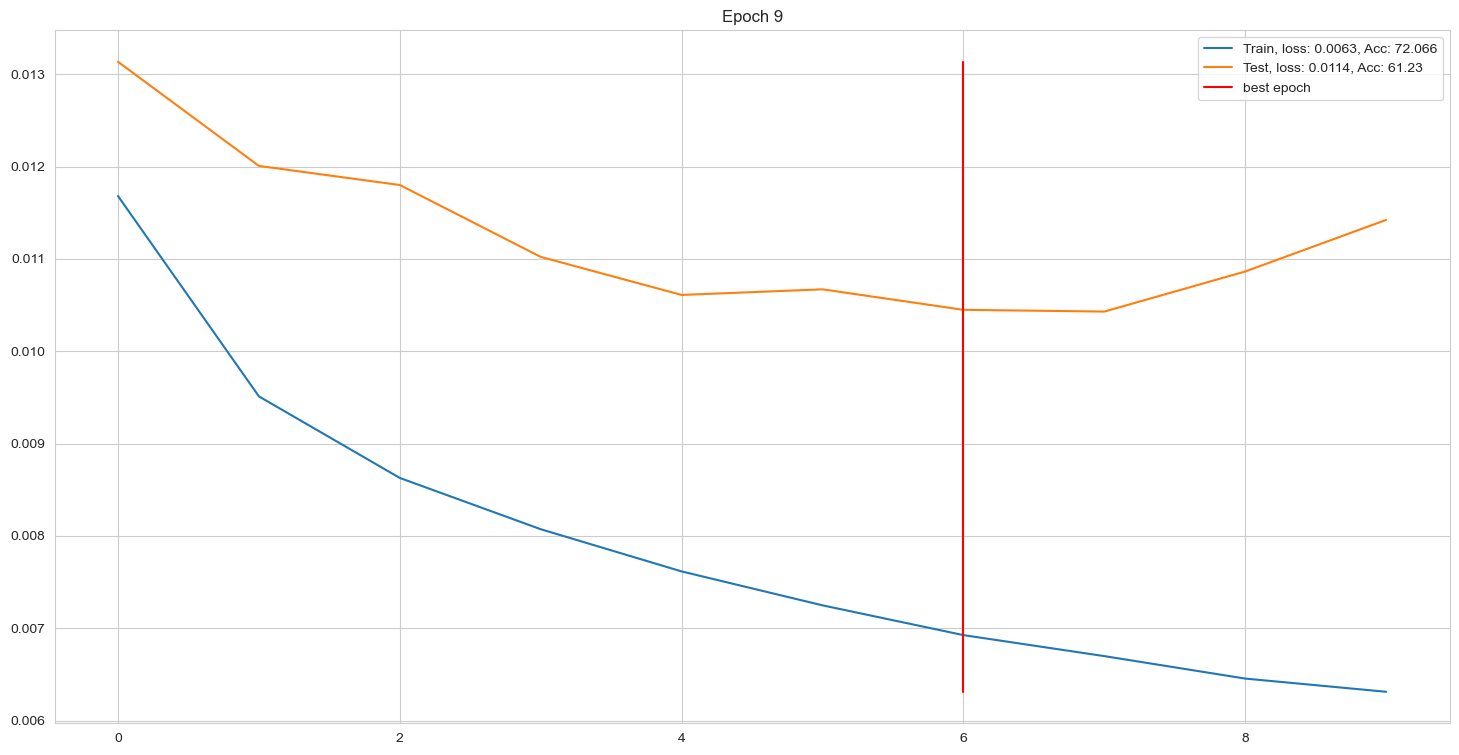

In [40]:
plt.figure(figsize=(18, 9))
plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
plt.plot(np.ones(10)*best_epoch, np.linspace(np.min(train_losses).item(), np.max(test_losses).item(), 10), color='r', label='best epoch')
plt.title(f'Epoch {i}')
plt.legend(loc='best')

## 4. Add some augmentations

https://pytorch.org/docs/stable/torchvision/transforms.html

Добавим пару аугментаций (`Crop` & `Flip`) и посмотрим, как изменится обучение

In [41]:
transform_train = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(25),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [42]:
model = nn.Sequential()

# dense "head"
model.add_module('conv1', nn.Conv2d(3, 64, 3))
model.add_module('bn1', nn.BatchNorm2d(64))
model.add_module('conv1_relu', nn.ReLU())
model.add_module('conv2', nn.Conv2d(64, 10, 3))
model.add_module('bn2', nn.BatchNorm2d(10))
model.add_module('conv2_relu', nn.ReLU())

model.add_module('flat', Flatten())
model.add_module('dense', nn.Linear(10*28*28, 10))

In [43]:
def train(model, optim, criterion, dataloader, epoch, device, add_noise=True):
    total = 0
    correct = 0
    train_loss = 0

    model.train()
    for data, label in dataloader:
        if add_noise:
            data = data + torch.empty(*data.size()).normal_(0, 0.0001)
        data, label = data.to(device), label.to(device)
        optim.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optim.step()

        train_loss += loss.item()
        pred = output.argmax(1)
        total += output.shape[0]
        correct += pred.eq(label).sum().item()
    return train_loss / total, 100. * correct / total

In [44]:
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

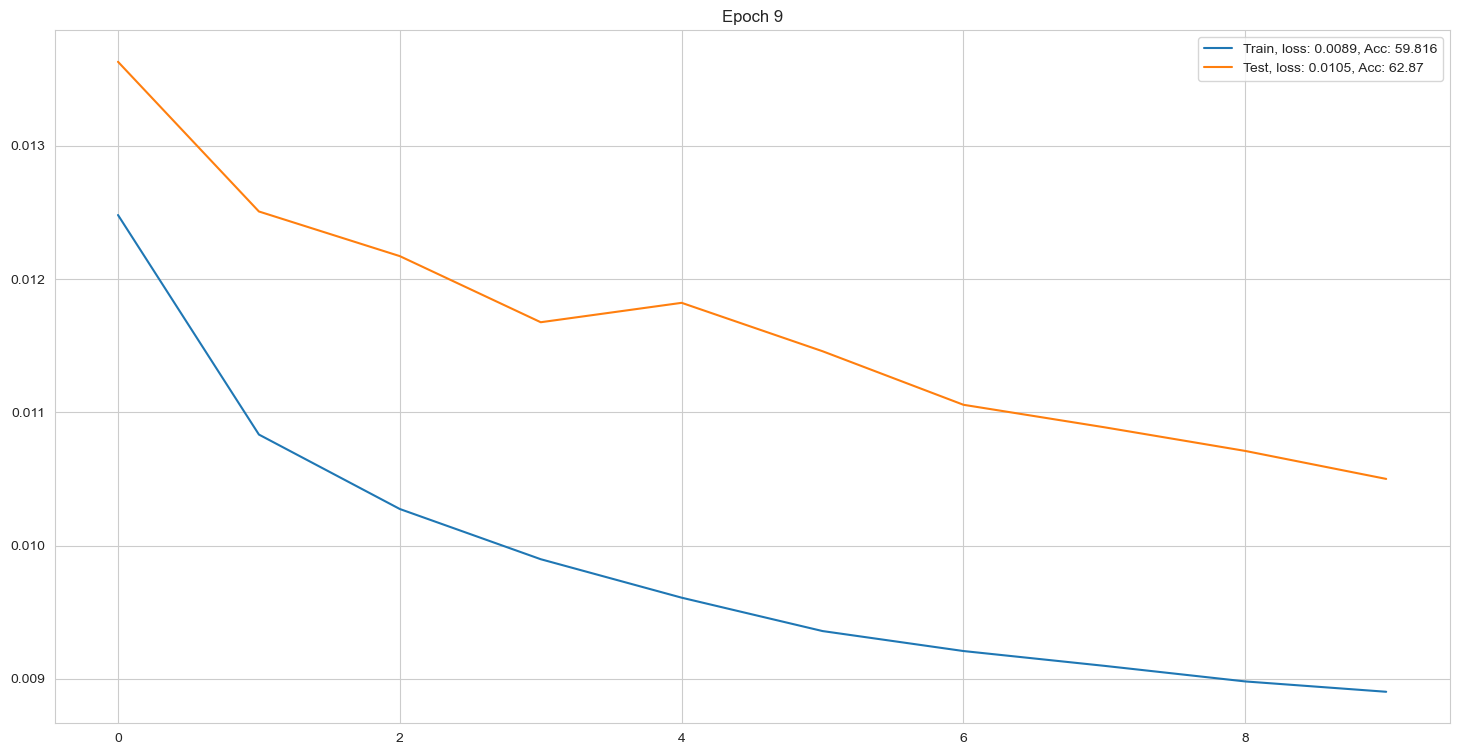

In [45]:
train_losses = []
test_losses = []
best_acc = 0
best_epoch = -1
for i in range(10):
    train_loss, train_acc = train(model, optimizer, criterion, trainloader, i, device)
    train_losses.append(train_loss)
    test_loss, test_acc = test(model, criterion, testloader, i, device, best_acc, 'bn_and_aug')
    scheduler.step(test_loss)
    test_losses.append(test_loss)
    best_acc = max(best_acc, test_acc)
    best_epoch = i if best_acc == test_acc else best_epoch
    clear_output()
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
    plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
    plt.title(f'Epoch {i}')
    plt.legend(loc='best')
    plt.show()